<a href="https://colab.research.google.com/github/marianvela/otto/blob/main/Proyecto_SP1_Detecting_Malaria.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Grupo 6:
Otto Chamo ,
Aarón Menchú ,
Marian Vela


Detecting Malaria (Computer Vision)

# 0) Preparations

In [ ]:
# ----- Libraries ----- #

# This is the main Library that allows us to work with Neural Networks
import tensorflow as tf
import tensorflow_hub as hub

# For graph plotting
import matplotlib.pyplot as plt
from tensorflow.math import confusion_matrix
from tensorflow.keras.utils import image_dataset_from_directory

# For dataset manipulation
from keras.preprocessing import image
import numpy as np

# Miscellaneous Libraries
import os, os.path  

# For visualizing more complex graphs
import seaborn as sns

# For easy file manipulation
import shutil 

# Global constant for training acceleration
AUTOTUNE = tf.data.AUTOTUNE

# 1) Dataset Loading

## Link Kaggle

In [ ]:
# Link kaggle with Colab
from google.colab import files
files.upload() #upload kaggle.json

!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
kaggle.json


In [ ]:
# Dataset Malaria : https://www.kaggle.com/datasets/iarunava/cell-images-for-detecting-malaria
!kaggle datasets download -d iarunava/cell-images-for-detecting-malaria

# unzip
!unzip cell-images-for-detecting-malaria.zip -d data

Streaming output truncated to the last 5000 lines.
  inflating: data/cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_116.png  
  inflating: data/cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_118.png  
  inflating: data/cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_126.png  
  inflating: data/cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_134.png  
  inflating: data/cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_141.png  
  inflating: data/cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_168.png  
  inflating: data/cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_175.png  
  inflating: data/cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_183.png  
  inflating: data/cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_221.png  
  inflating: data/cell_images/cell_images/Uninfected/C236ThinF_IMG_

In [ ]:
# Setting up Macro Variables
test_split = 0.2

# Directories
base_dir = "./data/"
or_dir = "./data/cell_images/"
train_dir = base_dir + "train/"
test_dir = base_dir + "test/"

In [ ]:
# Creating a train and test directory
!mkdir data/train
!mkdir data/test

# Creating the classes' directories
!mkdir data/train/Uninfected
!mkdir data/train/Parasitized
!mkdir data/test/Uninfected
!mkdir data/test/Parasitized

In [ ]:
!rm -r data/cell_images/cell_images

## Move files

In [ ]:
# Moving files to their respective directories
for malaria_class in ["Uninfected", "Parasitized"]:
  # Retrieving class' files
  class_files = [f for f in os.listdir(or_dir + malaria_class) if os.path.isfile(os.path.join(or_dir + malaria_class, f))]

  # Shuffling files
  np.random.shuffle(class_files)

  # Splitting classes
  test, train = np.split(class_files, [int(len(class_files) * test_split)])

  # Building the new path to the train image
  new_img_path = train_dir + malaria_class + "/"

  # Moving all train files
  for class_img in train:
    # Building the original path to the image
    base_img_path = or_dir + malaria_class + "/" + class_img

    ## use shutil here en vez de !mv
    ## https://pynative.com/python-move-files/
    ##!mv $base_img_path $new_img_path
    shutil.move(base_img_path, new_img_path)

  # Building the new path to the test image
  new_img_path = test_dir + malaria_class + "/" 

  # Moving all test files
  for class_img in test:
    # Building the original path to the image
    base_img_path = or_dir + malaria_class + "/" + class_img

    #!mv $base_img_path $new_img_path
    shutil.move(base_img_path, new_img_path)

In [ ]:
# Counting total of files in every class
for condition in ["Uninfected", "Parasitized"]:
  DIR = "./data/train/" + condition
  print(condition, len([name for
                     name in os.listdir(DIR) if os.path.isfile(os.path.join(DIR, name))]))
for condition in ["Uninfected", "Parasitized"]:
  DIR = "./data/test/" + condition
  print(condition, len([name for
                     name in os.listdir(DIR) if os.path.isfile(os.path.join(DIR, name))]))

Uninfected 11024
Parasitized 11024
Uninfected 2756
Parasitized 2756


## Create Datasets

In [ ]:
# MACROVARIABLES
# Standarizing Image size
img_width = 128
img_height = 128

# Setting up image shape
channels = 3
img_shape = (img_width, img_height, channels)

# Setting up Batch size
batch_size = 64

# Setting up Class Names
class_names = ["Uninfected", "Parasitized"] 
classes = len(class_names)

# Setting up seed
seed = 996633

# Setting up validation split
validation_split = 0.2

In [ ]:
# IMPORTANT: REFER TO THE DOCUMENTATION OF THE FUNCTION:
# https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory

# Creating Train Dataset
raw_train_dataset = tf.keras.utils.image_dataset_from_directory(
  # Give Directory's path
  train_dir,

  # Set to Inferred so the system automatically infers the labels
  labels='inferred',

  # Labels are encoded as 0 and 1
  label_mode="int",
  class_names=class_names,

  # Set to RGB since JPG images are in RGB
  color_mode="rgb",

  # Load in batches of 'batch_size'
  batch_size=batch_size,

  # Standarizes all images into the size put below
  image_size=(img_height, img_width),

  # Tells the portion of images that will belong to validation
  validation_split=validation_split,

  # Tells what kind of dataset it is creating: training or validation
  subset="training",

  # Sets the random generator seed into a custom number
  seed=seed,

  # Tells if data should be shuffled or not
  shuffle=True,
)

Found 22046 files belonging to 2 classes.
Using 17637 files for training.


In [ ]:
# Creating Validation Dataset
raw_validation_dataset = tf.keras.utils.image_dataset_from_directory(
  # Give Directory's path
  train_dir,

  # Set to Inferred so the system automatically infers the labels
  labels='inferred',

  # (Refer to Documentation) Labels are encoded as 0 and 1
  label_mode="int",
  class_names=class_names,

  # Set to RGB since JPG images are in RGB
  color_mode="rgb",

  # Load in batches of 'batch_size'
  batch_size=batch_size,

  # Standarizes all images into the size put below
  image_size=(img_height, img_width),

  # Tells the portion of images that will belong to validation
  validation_split=validation_split,

  # Tells what kind of dataset it is creating: training or validation
  subset="validation",

  # Sets the random generator seed into a custom number
  seed=seed,

  # Tells if data should be shuffled or not
  shuffle=True,
)

Found 22046 files belonging to 2 classes.
Using 4409 files for validation.


In [ ]:
# Creating Test Dataset
raw_test_dataset = tf.keras.utils.image_dataset_from_directory(
  # Give Directory's path
  test_dir,

  # Set to Inferred so the system automatically infers the labels
  labels='inferred',

  # (Refer to Documentation) Labels are encoded as 0 and 1
  label_mode="int",
  class_names=class_names,

  # Set to RGB since JPG images are in RGB
  color_mode="rgb",

  # Load in batches of 'batch_size'
  batch_size=batch_size,

  # Standarizes all images into the size put below
  image_size=(img_height, img_width),

  # Sets the random generator seed into a custom number
  seed=seed,

  # Tells if data should be shuffled or not
  shuffle=True,
)

Found 5512 files belonging to 2 classes.


## Visualize Dataset

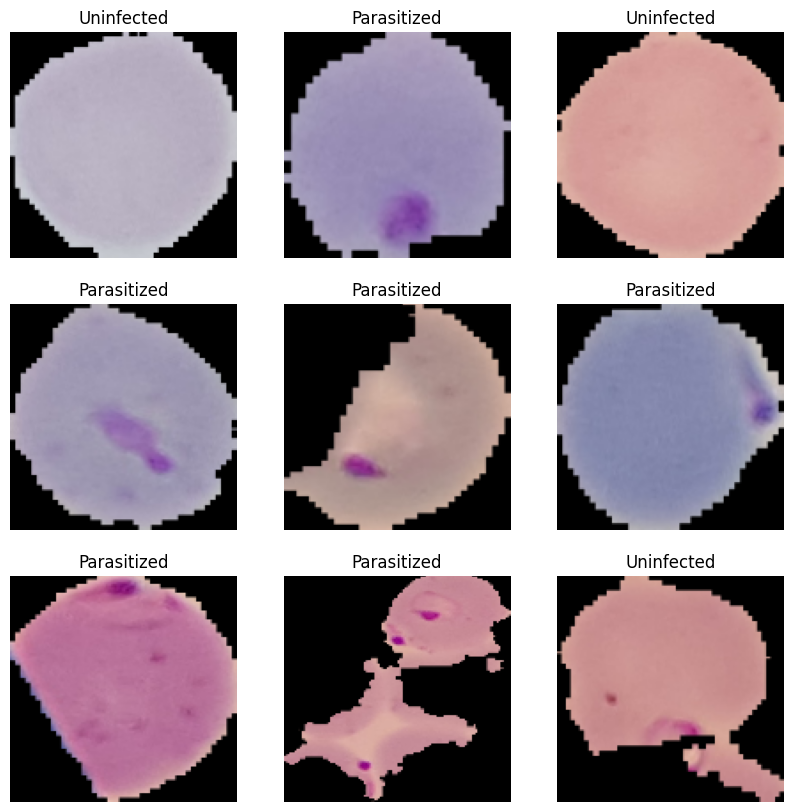

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in raw_train_dataset.take(1):
  #print(labels.numpy())
  for i in range(9):
    # Setting a graph plot for 3x3 images
    ax = plt.subplot(3, 3, i + 1)

    # Plotting the image. All images are converted to numpy and later casted to uint8
    plt.imshow(images[i].numpy().astype("uint8"))

    # Labels are converted from tensor to numpy numbers
    label = int(labels[i].numpy())
    plt.title(class_names[label])
    
    plt.axis("off")

# 2) Pre Processing

## Normalization

In [ ]:
# Defining the function for MinMax
minmax = tf.keras.layers.Rescaling(1./255)

# Normalizing
clean_train_dataset = raw_train_dataset.map(lambda x, y: (minmax(x), y))
clean_validation_dataset = raw_validation_dataset.map(lambda x, y: (minmax(x), y))
clean_test_dataset = raw_test_dataset.map(lambda x, y: (minmax(x), y))

## Performance

In [ ]:
# This is to take advantage of Cache and prevent I/O operations from blocking the training pipeline
AUTOTUNE = tf.data.AUTOTUNE

clean_train_dataset = clean_train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
clean_validation_dataset = clean_validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)
clean_test_dataset = clean_test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

# -- Transfer Learning --

# 3) AI Model with TL

In [ ]:
# Early Stopping Callback
earlystopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.01, patience=4,)

In [ ]:
# Lets create the directory to store the checkpoints
checkpoint_path = "training_TL/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Lets create the actual Callback
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    save_freq='epoch'
  )

In [ ]:
classifier_model ="https://tfhub.dev/google/imagenet/mobilenet_v2_100_128/classification/5"

In [ ]:
classifier = hub.KerasLayer(
    classifier_model, 
    input_shape=img_shape,
    trainable=False)

In [ ]:
# Lets build the model. NOTE: this is the construction of the architecture of the model!
model_TL = tf.keras.models.Sequential([
  # Feature Extraction using the other model!
  classifier,

  # NN for classification
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(units=128, activation='relu'),
  tf.keras.layers.Dense(units=len(class_names), activation='softmax')
  ])

# Now lets compile the model. NOTE: These are the finishing touches before having a fully functional model
model_TL.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), optimizer='adam', metrics=['accuracy'])

# Now lets train the model!
model_TL.fit(x = clean_train_dataset,
          validation_data = clean_validation_dataset,
          epochs=100,
          batch_size = 512,
          validation_split=0.2,
          callbacks=[checkpoint_callback, earlystopping_callback]
        )

Epoch 1/100
276/276 [==============================] - ETA: 0s - loss: 0.2633 - accuracy: 0.8976
Epoch 1: val_loss improved from inf to 0.20811, saving model to training_TL/cp-0001.ckpt
276/276 [==============================] - 18s 20ms/step - loss: 0.2633 - accuracy: 0.8976 - val_loss: 0.2081 - val_accuracy: 0.9199
Epoch 2/100
271/276 [============================>.] - ETA: 0s - loss: 0.1946 - accuracy: 0.9253
Epoch 2: val_loss improved from 0.20811 to 0.19570, saving model to training_TL/cp-0002.ckpt
276/276 [==============================] - 4s 14ms/step - loss: 0.1952 - accuracy: 0.9253 - val_loss: 0.1957 - val_accuracy: 0.9270
Epoch 3/100
272/276 [============================>.] - ETA: 0s - loss: 0.1828 - accuracy: 0.9298
Epoch 3: val_loss improved from 0.19570 to 0.18591, saving model to training_TL/cp-0003.ckpt
276/276 [==============================] - 4s 13ms/step - loss: 0.1838 - accuracy: 0.9296 - val_loss: 0.1859 - val_accuracy: 0.9306
Epoch 4/100
275/276 [================

# 4) Evaluate

In [ ]:
# Checking the last checkpoint - in this case, the last checkpoint is considered the 'best'
last_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)

# Loading the weights into the model
model_TL.load_weights("training_TL/cp-0003.ckpt")

In [ ]:
model_TL.evaluate(clean_test_dataset)

87/87 [==============================] - 1s 12ms/step - loss: 0.1891 - accuracy: 0.9314


[0.18911989033222198, 0.9314223527908325]

### Confusion Matrix

In [ ]:
# define func to plot confusion matrix
def plot_confusion_matrix(labels, predictions):
  figure = plt.figure(figsize=(6, 6))
  sns.heatmap(confusion_matrix(labels=labels, predictions=predictions), annot=True,cmap=plt.cm.Blues)
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

In [ ]:
# Declare vars
model_predictions = []
test_labels = []

for image_batch, labels_batch in clean_test_dataset:
  # Do predictions
  predictions = model_TL.predict(x=image_batch)
  predictions = list(map(lambda x: np.argmax(x), predictions))

  # Extracting labels
  labels = list(map(lambda x: int(x), labels_batch.numpy()))
  
  # Appending
  model_predictions += predictions
  test_labels += labels

1/1 [==============================] - 0s 490ms/step


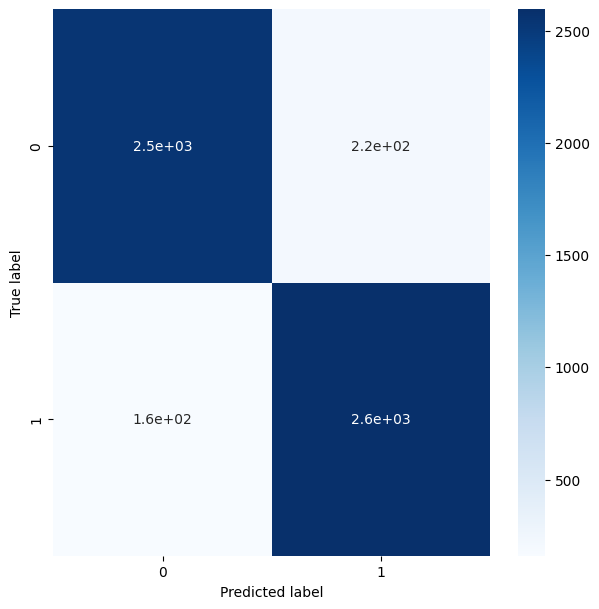

In [ ]:
# plot the confusion matrix
plot_confusion_matrix(labels=test_labels, predictions=model_predictions)

# -- Custom Model 1 -- 

# 5) AI Model 

### Callbacks

In [ ]:
# define callbacks 
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='logs/model/', histogram_freq=1)
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint('logs/model/', monitor='val_loss', verbose=1, save_best_only=True, mode='min',save_freq='epoch')
earlystopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.01, patience=2,)

### Architecture

In [ ]:
model_custom = tf.keras.models.Sequential([
    
  # Feature Extraction
  tf.keras.layers.InputLayer(input_shape=img_shape),
  
  tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), strides=(1,1), activation='relu'), 
  tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(1,1)),
  tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(1,1), activation='relu'),
  tf.keras.layers.AveragePooling2D(pool_size=(2,2), strides=(1,1)),

  # reducimos dimensionalidad a un vector
  tf.keras.layers.Flatten(),

  # NN model
  tf.keras.layers.Dense(128, activation=tf.nn.relu),
  tf.keras.layers.Dropout(rate=0.10),
  tf.keras.layers.Dense(units=64, activation='relu'),

  # 2 neuronas de output por cada clase
  tf.keras.layers.Dense(2, activation=tf.nn.softmax)
  ])

In [ ]:
# compile model. sparse categorical cross entropy as loss for multi class problem
model_custom.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), optimizer='adam', metrics=['accuracy'])

model_custom.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 125, 125, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 123, 123, 32)      18464     
                                                                 
 average_pooling2d (AverageP  (None, 122, 122, 32)     0         
 ooling2D)                                                       
                                                                 
 flatten_1 (Flatten)         (None, 476288)            0         
                                                                 
 dense_2 (Dense)             (None, 128)              

In [ ]:
# Now lets train the model!
model_custom.fit(x=clean_train_dataset,
          validation_data=clean_validation_dataset,
          epochs=50,
          callbacks=[earlystopping_callback]
        )

Epoch 1/50
276/276 [==============================] - 10s 22ms/step - loss: 0.8593 - accuracy: 0.5837 - val_loss: 0.6571 - val_accuracy: 0.6212
Epoch 2/50
276/276 [==============================] - 6s 20ms/step - loss: 0.6320 - accuracy: 0.6422 - val_loss: 0.6504 - val_accuracy: 0.6235
Epoch 3/50
276/276 [==============================] - 6s 20ms/step - loss: 0.5449 - accuracy: 0.7230 - val_loss: 0.7407 - val_accuracy: 0.6022


# 6) Evaluate

In [ ]:
# Checking the last checkpoint - in this case, the last checkpoint is considered the 'best'
last_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)

# Loading the weights into the model
model_custom.load_weights("training/cp-0002.ckpt")

NotFoundError: ignored

In [ ]:
model_custom.evaluate(clean_test_dataset)

### Confusion Matrix

In [ ]:
# define func to plot confusion matrix
def plot_confusion_matrix(labels, predictions):
  figure = plt.figure(figsize=(6, 6))
  sns.heatmap(confusion_matrix(labels=labels, predictions=predictions), annot=True,cmap=plt.cm.Blues)
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

In [ ]:
# Declare vars
model_predictions = []
test_labels = []

for image_batch, labels_batch in clean_test_dataset:
  # Do predictions
  predictions = model_custom.predict(x=image_batch)
  predictions = list(map(lambda x: np.argmax(x), predictions))

  # Extracting labels
  labels = list(map(lambda x: int(x), labels_batch.numpy()))
  
  # Appending
  model_predictions += predictions
  test_labels += labels

In [ ]:
# check if there's bias
plot_confusion_matrix(labels=test_labels, predictions=model_predictions)

# -- Custom Model 2 -- 

# 7) AI Model 

# 8) Evaluate